In [27]:
## General imports
import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import random
from tqdm import tqdm
from scipy.stats import norm
from scipy import stats

## Own functionality imports
"""
Could not make this work
"""
# import sys
# sys.path.append('..')
# from scripts.functions import read_daily, remove_outlier, verdeling

'\nCould not make this work\n'

In [2]:
def read_daily(city):
    """
    Takes in an abbreviation of a city and reads its json files to a dataframe.
    """

    folder_daily = locs[f"input_daily_{city}"]

    # import all files which end with .json from folder
    json_files = glob.glob(os.path.join(folder_daily, '*.json'))
    
    json_list = []
    for file in tqdm(json_files):
        with open(file, 'r') as f:
            data = json.load(f)
        json_list.append(data)
    
    # convert list of dfs to dataframe
    df_daily = pd.json_normalize(json_list)
    return df_daily

def remove_outlier(df):
    """
    Takes in data frame of 1 column (prod_daily) and removes the outliers.
    """
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1 #Interquartile range
    tresh_low  = q1-1.5*iqr
    tresh_high = q3+1.5*iqr
    df_out = df.loc[(df > tresh_low) & (df < tresh_high)]
    return df_out, tresh_low, tresh_high

def verdeling(perc_0, perc_out_low, perc_prod, perc_out_high, msr, avg, std, sample_size = 10 ** 3):
    """
    Functie genereert simulatie data obv parameters van betreffende stad voor n dagen
    TODO: better option for 0 productie
    """
    distributions = [
        {'type': np.random.normal, 'kwargs': {'loc': 0, 'scale': 1/100}},
        {'type': np.random.uniform, 'kwargs': {'low': 0, 'high': tresh_low}},
        {'type': np.random.normal, 'kwargs': {'loc': avg, 'scale': std}},
        {'type': np.random.uniform, 'kwargs': {'low': tresh_high, 'high': msr}}
    ]
    coeff = np.array([perc_0, perc_out_low, perc_prod, perc_out_high])
    coeff /= coeff.sum()
    num_dis = len(distributions)

    data = np.zeros((sample_size, num_dis))
    for idx, distr in enumerate(distributions):
        data[:, idx] = distr['type'](size = (sample_size,), **distr['kwargs'])
    random_idx = np.random.choice(np.arange(num_dis), size = (sample_size,), p = coeff)
    sim_data = data[np.arange(sample_size), random_idx]
    return sim_data

## Define locations

In [3]:
locs = {'input_master_data' : os.path.join('..', 'data', 'input', 'data_productie', 'master_data.json'),
        'input_daily_BRU' : os.path.join('..', 'data', 'input', 'data_productie', 'daily_production', 'BRU'),
        'input_daily_STO' : os.path.join('..', 'data', 'input', 'data_productie', 'daily_production', 'STO')}
locs

{'input_master_data': '..\\data\\input\\data_productie\\master_data.json',
 'input_daily_BRU': '..\\data\\input\\data_productie\\daily_production\\BRU',
 'input_daily_STO': '..\\data\\input\\data_productie\\daily_production\\STO'}

## Read data

In [4]:
with open(locs['input_master_data'], 'r') as f:
    data_raw = json.load(f)
msr_data = pd.json_normalize(data_raw)
msr_data

,BRU msr,STO msr
0,1244,274


> **choose city 'BRU' or 'STO'**

In [5]:
city = 'BRU'
df_daily_raw = read_daily(city)
df_daily_raw

100%|████████████████████████████████████████████████████████████████████████████| 1830/1830 [00:00<00:00, 1884.08it/s]


,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production
0,Monday,1,0,01-01-2018 00:00:00.0000,No,61,5,1183
1,Tuesday,1,0,01-02-2018 00:00:00.0000,No,106,9,1138
2,Wednesday,1,0,01-03-2018 00:00:00.0000,No,129,10,1115
3,Thursday,1,0,01-04-2018 00:00:00.0000,No,278,22,966
4,Friday,1,0,01-05-2018 00:00:00.0000,No,218,17,1026
...,...,...,...,...,...,...,...,...
1825,Saturday,1,0,12-31-2022 00:00:00.0000,No,203,16,1041
1826,Sunday,1,0,01-01-2023 00:00:00.0000,No,231,19,1013
1827,Monday,1,0,01-02-2023 00:00:00.0000,No,181,15,1063
1828,Tuesday,1,0,01-03-2023 00:00:00.0000,No,198,16,1046


## Clean data

In [6]:
df_daily = df_daily_raw.copy()

# change type to numeric and change #MV (maintenance -> no production) to Nan
df_daily[['prod_loss', 'prod_loss_perc', 'production']] = (df_daily[['prod_loss', 'prod_loss_perc', 'production']]
                                                            .apply(pd.to_numeric, downcast='unsigned', errors='coerce'))
# increase readability of the date and delete useless columns
df_daily[['date', 'time_ignore']] = df_daily['date'].str.split(' ', expand = True)
df_daily = df_daily.drop(['time_ignore', 'minute', 'hour'], axis = 1)

## Explore

In [7]:
df_daily.sample(10)

,DoW,date,maintenance,prod_loss,prod_loss_perc,production
120,Tuesday,05-01-2018,Yes,NaN,NaN,NaN
1427,Sunday,11-28-2021,No,160.0,13.0,1084.0
1453,Friday,12-24-2021,No,326.0,26.0,918.0
947,Wednesday,08-05-2020,No,57.0,5.0,1187.0
1310,Tuesday,08-03-2021,No,178.0,14.0,1066.0
676,Friday,11-08-2019,No,281.0,23.0,963.0
1815,Wednesday,12-21-2022,No,424.0,34.0,820.0
586,Saturday,08-10-2019,No,303.0,24.0,941.0
787,Thursday,02-27-2020,No,366.0,29.0,878.0
1171,Wednesday,03-17-2021,No,1244.0,100.0,0.0


In [8]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DoW             1830 non-null   object 
 1   date            1830 non-null   object 
 2   maintenance     1830 non-null   object 
 3   prod_loss       1736 non-null   float64
 4   prod_loss_perc  1736 non-null   float64
 5   production      1736 non-null   float64
dtypes: float64(3), object(3)
memory usage: 85.9+ KB


In [9]:
df_daily.describe()

,prod_loss,prod_loss_perc,production
count,1736.000000,1736.000000,1736.000000
mean,430.288018,34.579493,813.711982
std,390.712496,31.413713,390.712496
min,51.000000,4.000000,0.000000
25%,196.750000,16.000000,860.750000
50%,270.500000,22.000000,973.500000
75%,383.250000,31.000000,1047.250000
max,1244.000000,100.000000,1193.000000


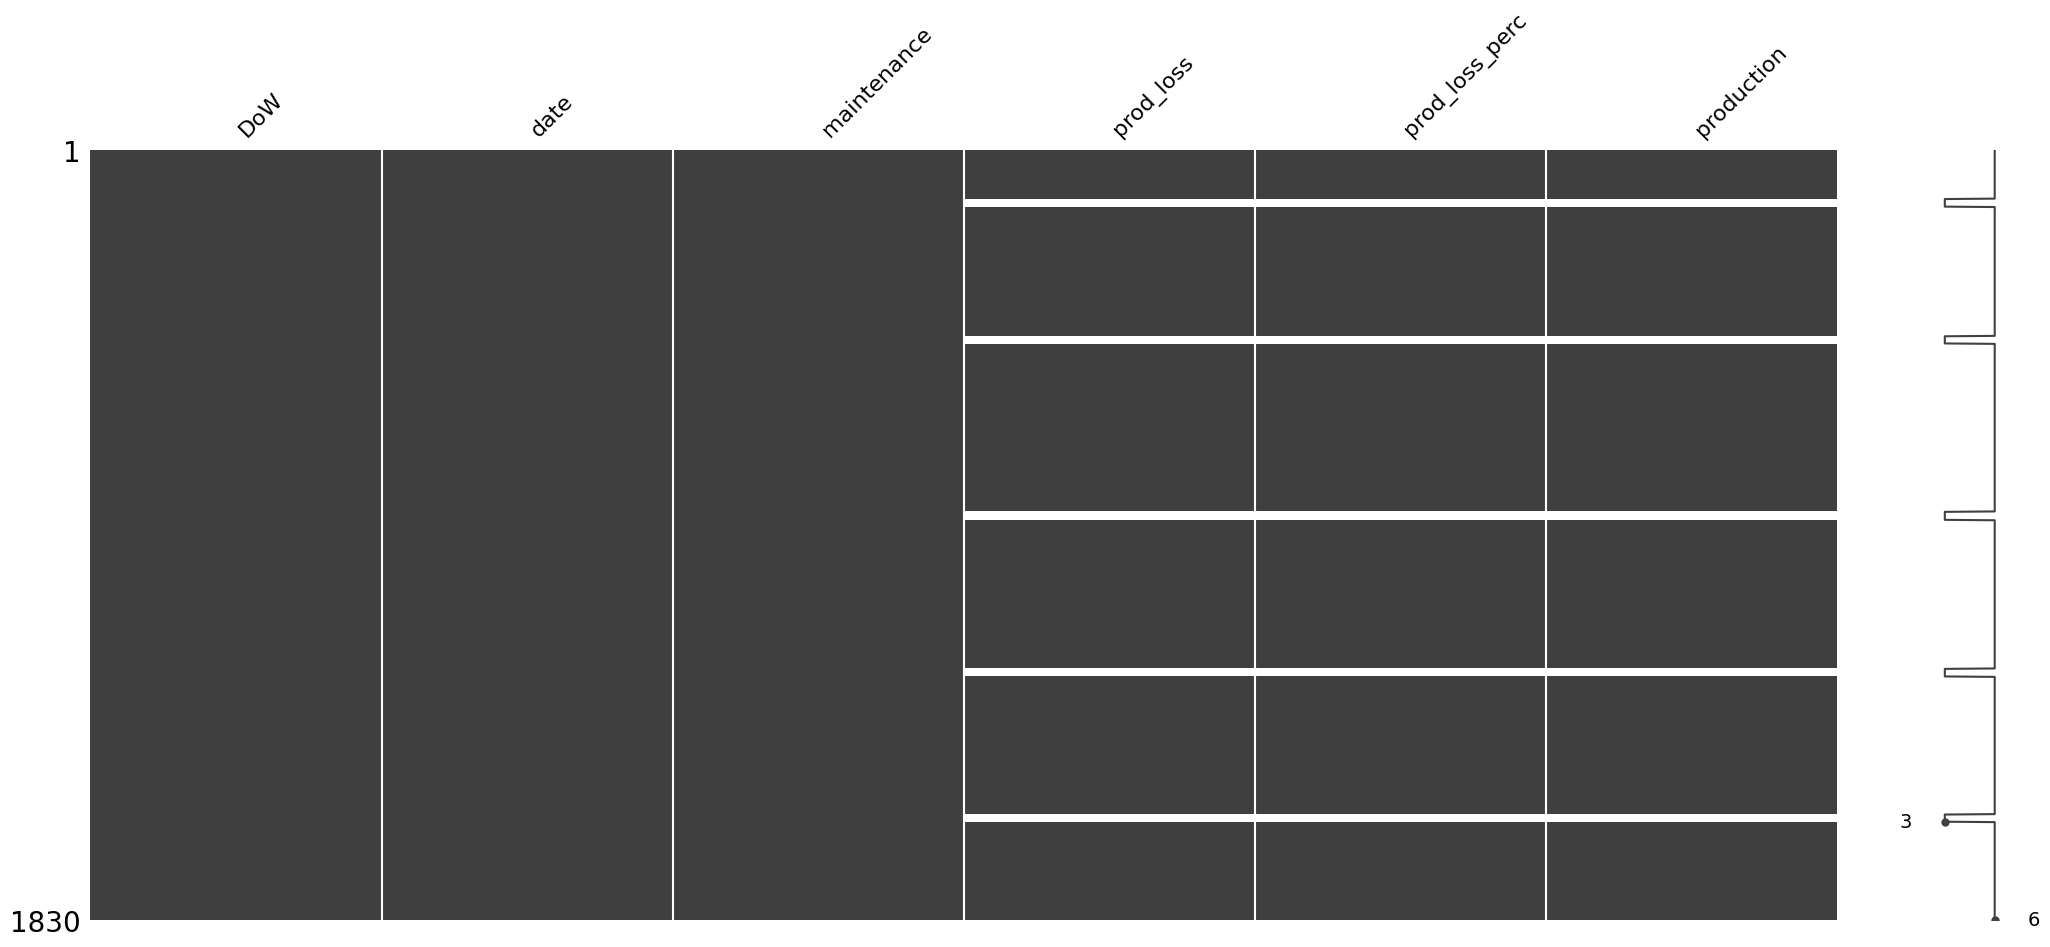

In [10]:
# check where missing values are
msno.matrix(df_daily);

In [11]:
# verify if all missing values coincide with maintenance
verify_df = df_daily.loc[df_daily['prod_loss'].isna(), 'maintenance'].eq('Yes').all()
verify_df

True

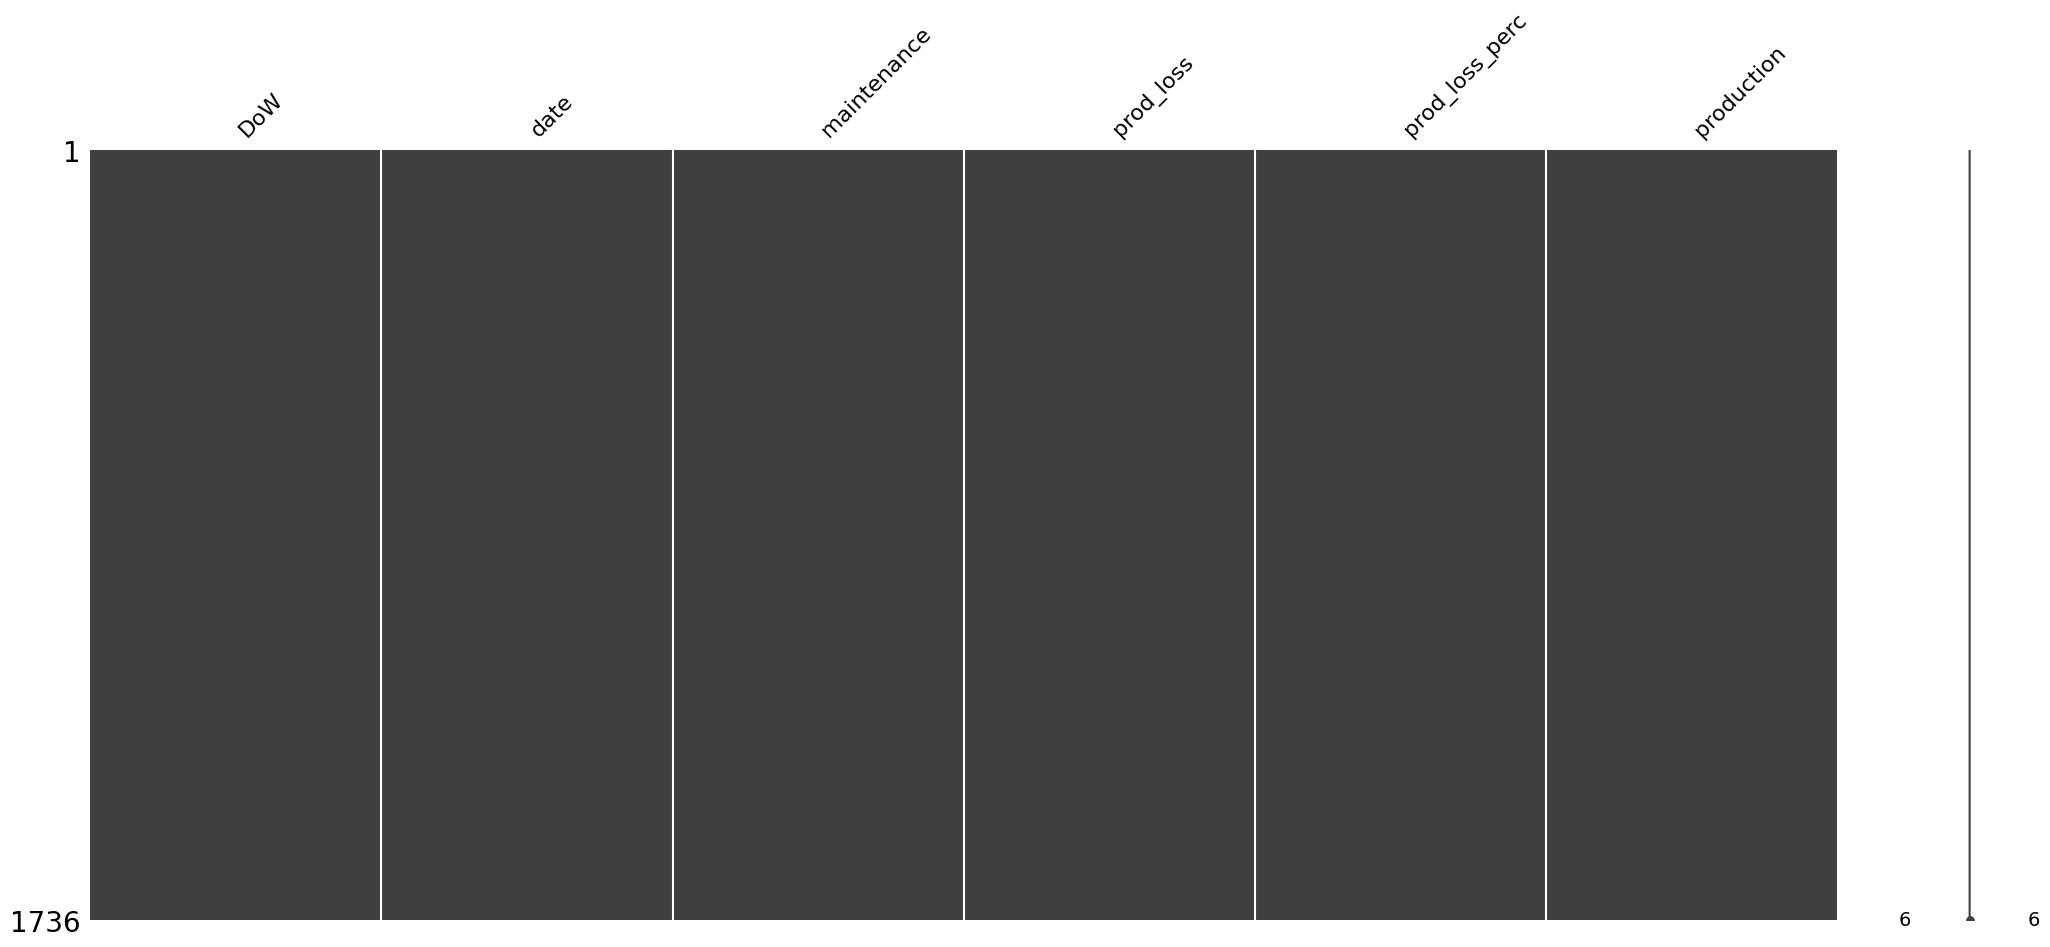

In [12]:
# maintenance is planned, so not in simulation
df_daily_noMT = df_daily.dropna()
msno.matrix(df_daily_noMT);

## Visualize

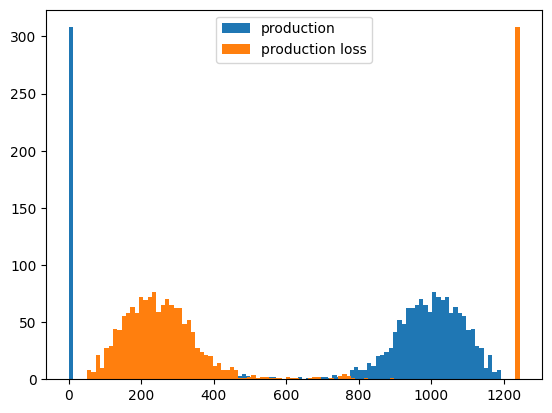

In [13]:
plt.hist(df_daily_noMT['production'], bins = 100, label = 'production');
plt.hist(df_daily_noMT['prod_loss'], bins = 100, label = 'production loss');
plt.legend();

## Parameters and subsets

In [14]:
# column to variable
prod_daily = df_daily_noMT['production']

# Maximal Sustainable Rate
msr = msr_data.iloc[0][f'{city} msr']
print('Maximal Sustainable Rate is', msr)

# 0 productie
perc_0 = np.mean(prod_daily < 10 ** (-1))
print('Kans op 0 productie is', f"{perc_0:.2%}")

# niet 0 en outliers
prod_not_0 = prod_daily[prod_daily > 10 ** (-1)]
outliers_gone = remove_outlier(prod_not_0)
prod_not_out = outliers_gone[0]
tresh_low = outliers_gone[1]
tresh_high = outliers_gone[2]
perc_out_low = sum(i < tresh_low for i in prod_not_0)/prod_daily.shape[0]
perc_out_high = sum(i > tresh_high for i in prod_not_0)/prod_daily.shape[0]
print('Kans op outlier productie onder', tresh_low, 'is', f"{perc_out_low:.2%}")
print('Kans op outlier productie boven', tresh_high, 'is', f"{perc_out_high:.2%}")

# kans op normale productie
perc_prod = 1 - (perc_0 + perc_out_low + perc_out_high)
print('Kans op normale productie is', f"{perc_prod:.2%}")

Maximal Sustainable Rate is 1244
Kans op 0 productie is 17.74%
Kans op outlier productie onder 744.875 is 2.13%
Kans op outlier productie boven 1253.875 is 0.00%
Kans op normale productie is 80.13%


In [15]:
avg = np.mean(prod_not_out)
std = np.std(prod_not_out)
print('gemiddelde: ', avg, '\nstd: ', std)

gemiddelde:  999.9705248023005 
std:  85.99802629068185


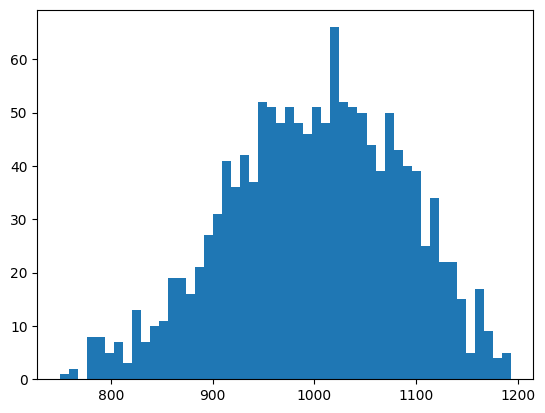

In [16]:
plt.hist(prod_not_out, bins = 50);

## Fit distributie

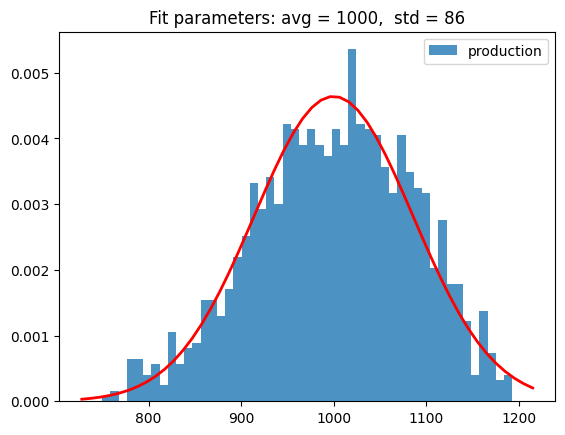

In [17]:
# fit normal distribution to the data
avg, std = norm.fit(prod_not_out)

# plot histogram
plt.hist(prod_not_out, bins = 50, density = True, alpha = 0.8, label = 'production')
plt.legend()

# plot pdf
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 50)
p = norm.pdf(x, avg, std)
plt.plot(x, p, 'r', linewidth = 2)
title = "Fit parameters: avg = %.0f,  std = %.0f" % (avg, std)
plt.title(title)

plt.show()

## Verdeling

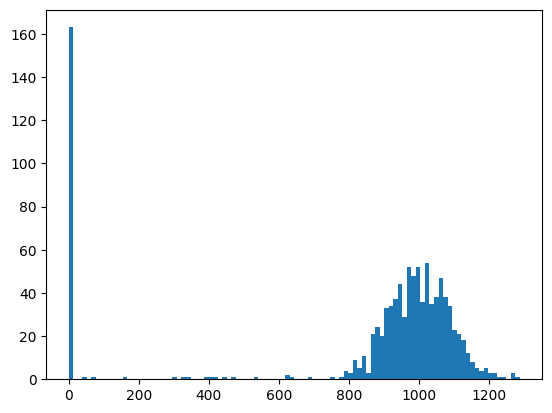

In [18]:
# maak verdeling
my_verd = verdeling(perc_0, perc_out_low, perc_prod, perc_out_high, msr, avg, std)

# Plot verdeling
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax)
plt.hist(my_verd, bins = 100);

## Simulatie programma

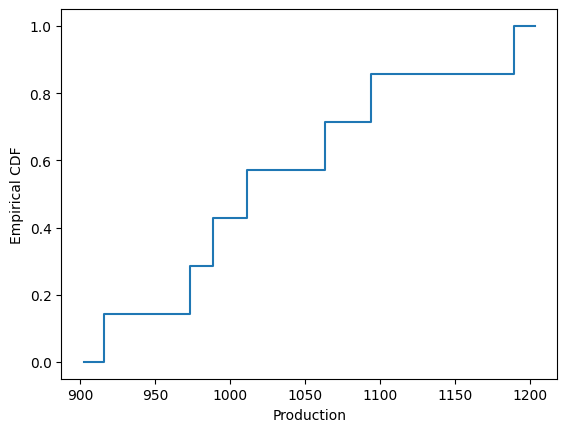

In [42]:
number_of_days = 7
np.random.seed(42)
prod_in_x_days = np.random.choice(my_verd, size = number_of_days)
res = stats.ecdf(prod_in_x_days)
ax = plt.subplot()
res.cdf.plot(ax)
ax.set_xlabel('Production')
ax.set_ylabel('Empirical CDF')
plt.show()